In [1]:
import joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier



**Read and shuffle the dataset**

In [3]:
df = pd.read_csv('../datasets/quick_checkup/symptom-disease.csv')
df = shuffle(df,random_state=42)

**Removing Hyphen from strings**

In [4]:
for col in df.columns:
    
    df[col] = df[col].str.replace('_',' ')
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
1614,GERD,stomach pain,acidity,ulcers on tongue,vomiting,chest pain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4726,Hyperthyroidism,fatigue,mood swings,weight loss,restlessness,sweating,diarrhoea,fast heart rate,excessive hunger,muscle weakness,irritability,abnormal menstruation,NaN,NaN,NaN,NaN,NaN,NaN
4479,Hypothyroidism,fatigue,weight gain,cold hands and feets,mood swings,lethargy,dizziness,puffy face and eyes,enlarged thyroid,brittle nails,swollen extremeties,depression,irritability,abnormal menstruation,NaN,NaN,NaN,NaN
742,Arthritis,stiff neck,swelling joints,movement stiffness,painful walking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3473,Bronchial Asthma,fatigue,cough,high fever,breathlessness,family history,mucoid sputum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Dataset characteristics**

In [5]:
df.describe()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4858,4858,4858,4858,4558,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,47,53,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,GERD,vomiting,vomiting,fatigue,high fever,headache,nausea,abdominal pain,abdominal pain,yellowing of eyes,yellowing of eyes,irritability,malaise,abnormal menstruation,chest pain,chest pain,blood in sputum,muscle pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


**Check for null and NaN values**

In [6]:
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

            count
Disease         0
Symptom_1       0
Symptom_2       0
Symptom_3       0
Symptom_4     300
Symptom_5    1144
Symptom_6    1924
Symptom_7    2590
Symptom_8    2914
Symptom_9    3166
Symptom_10   3346
Symptom_11   3664
Symptom_12   4114
Symptom_13   4354
Symptom_14   4552
Symptom_15   4618
Symptom_16   4666
Symptom_17   4786


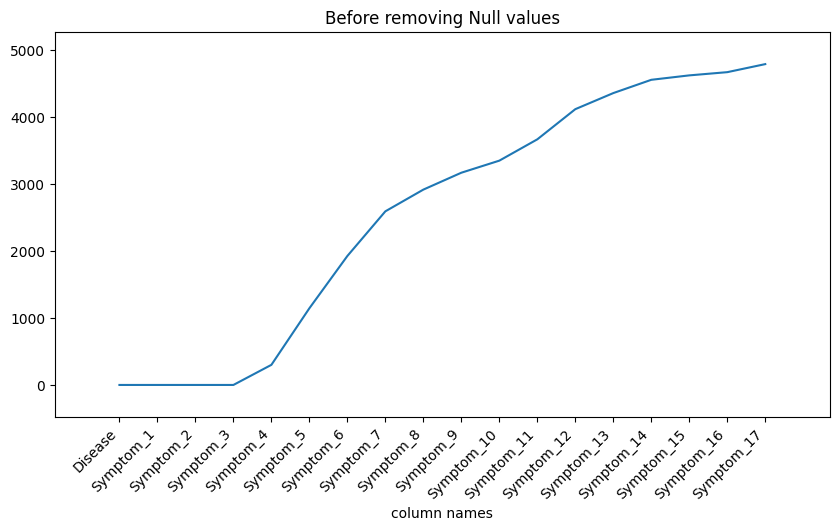

In [7]:
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45,
horizontalalignment='right')
plt.title('Before removing Null values')
plt.xlabel('column names')
plt.margins(0.1)
plt.show()

**Remove the trailing space from the symptom columns**

In [8]:
cols = df.columns
data = df[cols].values.flatten()

s = pd.Series(data)
s = s.str.strip()
s = s.values.reshape(df.shape)

df = pd.DataFrame(s, columns=df.columns)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,GERD,stomach pain,acidity,ulcers on tongue,vomiting,chest pain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hyperthyroidism,fatigue,mood swings,weight loss,restlessness,sweating,diarrhoea,fast heart rate,excessive hunger,muscle weakness,irritability,abnormal menstruation,NaN,NaN,NaN,NaN,NaN,NaN
2,Hypothyroidism,fatigue,weight gain,cold hands and feets,mood swings,lethargy,dizziness,puffy face and eyes,enlarged thyroid,brittle nails,swollen extremeties,depression,irritability,abnormal menstruation,NaN,NaN,NaN,NaN
3,Arthritis,stiff neck,swelling joints,movement stiffness,painful walking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bronchial Asthma,fatigue,cough,high fever,breathlessness,family history,mucoid sputum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Fill the NaN values with zero**

In [9]:
df = df.fillna(0)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,GERD,stomach pain,acidity,ulcers on tongue,vomiting,chest pain,0,0,0,0,0,0,0,0,0,0,0,0
1,Hyperthyroidism,fatigue,mood swings,weight loss,restlessness,sweating,diarrhoea,fast heart rate,excessive hunger,muscle weakness,irritability,abnormal menstruation,0,0,0,0,0,0
2,Hypothyroidism,fatigue,weight gain,cold hands and feets,mood swings,lethargy,dizziness,puffy face and eyes,enlarged thyroid,brittle nails,swollen extremeties,depression,irritability,abnormal menstruation,0,0,0,0
3,Arthritis,stiff neck,swelling joints,movement stiffness,painful walking,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bronchial Asthma,fatigue,cough,high fever,breathlessness,family history,mucoid sputum,0,0,0,0,0,0,0,0,0,0,0


**Symptom severity rank**

In [10]:
df1 = pd.read_csv('../datasets/quick_checkup/Symptom-severity.csv')
df1['Symptom'] = df1['Symptom'].str.replace('_',' ')
df1.head()

,Symptom,weight
0,itching,1
1,skin rash,3
2,nodal skin eruptions,4
3,continuous sneezing,4
4,shivering,5


**Get overall list of symptoms**

In [11]:
df1['Symptom'].unique()

array(['itching', 'skin rash', 'nodal skin eruptions',
       'continuous sneezing', 'shivering', 'chills', 'joint pain',
       'stomach pain', 'acidity', 'ulcers on tongue', 'muscle wasting',
       'vomiting', 'burning micturition', 'spotting urination', 'fatigue',
       'weight gain', 'anxiety', 'cold hands and feets', 'mood swings',
       'weight loss', 'restlessness', 'lethargy', 'patches in throat',
       'irregular sugar level', 'cough', 'high fever', 'sunken eyes',
       'breathlessness', 'sweating', 'dehydration', 'indigestion',
       'headache', 'yellowish skin', 'dark urine', 'nausea',
       'loss of appetite', 'pain behind the eyes', 'back pain',
       'constipation', 'abdominal pain', 'diarrhoea', 'mild fever',
       'yellow urine', 'yellowing of eyes', 'acute liver failure',
       'fluid overload', 'swelling of stomach', 'swelled lymph nodes',
       'malaise', 'blurred and distorted vision', 'phlegm',
       'throat irritation', 'redness of eyes', 'sinus pressu

**Encode symptoms in the data with the symptom rank**

In [12]:
vals = df.values
symptoms = df1['Symptom'].unique()

for i in range(len(symptoms)):
    vals[vals == symptoms[i]] = df1[df1['Symptom'] == symptoms[i]]['weight'].values[0]
    
d = pd.DataFrame(vals, columns=cols)
d.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,GERD,5,3,4,5,7,0,0,0,0,0,0,0,0,0,0,0,0
1,Hyperthyroidism,4,3,3,5,3,6,5,4,2,2,6,0,0,0,0,0,0
2,Hypothyroidism,4,3,5,3,2,4,5,6,5,5,3,2,6,0,0,0,0
3,Arthritis,4,5,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bronchial Asthma,4,4,7,4,5,4,0,0,0,0,0,0,0,0,0,0,0


**Assign symptoms with no rank to zero**

In [13]:
d = d.replace('dischromic  patches', 0)
d = d.replace('spotting  urination',0)
df = d.replace('foul smell of urine',0)
df.head(10)

C:\Users\Josia Given S\AppData\Local\Temp\ipykernel_25256\969436745.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d = d.replace('dischromic  patches', 0)
C:\Users\Josia Given S\AppData\Local\Temp\ipykernel_25256\969436745.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d = d.replace('spotting  urination',0)
C:\Users\Josia Given S\AppData\Local\Temp\ipykernel_25256\969436745.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly 

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,GERD,5,3,4,5,7,0,0,0,0,0,0,0,0,0,0,0,0
1,Hyperthyroidism,4,3,3,5,3,6,5,4,2,2,6,0,0,0,0,0,0
2,Hypothyroidism,4,3,5,3,2,4,5,6,5,5,3,2,6,0,0,0,0
3,Arthritis,4,5,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bronchial Asthma,4,4,7,4,5,4,0,0,0,0,0,0,0,0,0,0,0
5,Dimorphic hemmorhoids(piles),4,5,6,5,6,0,0,0,0,0,0,0,0,0,0,0,0
6,(vertigo) Paroymsal Positional Vertigo,5,3,5,6,4,4,0,0,0,0,0,0,0,0,0,0,0
7,Fungal infection,1,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Hypertension,3,7,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Paralysis (brain hemorrhage),5,3,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0


**Check if entire columns have zero values so we can drop those values**

In [14]:
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

            count
Disease         0
Symptom_1       0
Symptom_2       0
Symptom_3       0
Symptom_4       0
Symptom_5       0
Symptom_6       0
Symptom_7       0
Symptom_8       0
Symptom_9       0
Symptom_10      0
Symptom_11      0
Symptom_12      0
Symptom_13      0
Symptom_14      0
Symptom_15      0
Symptom_16      0
Symptom_17      0


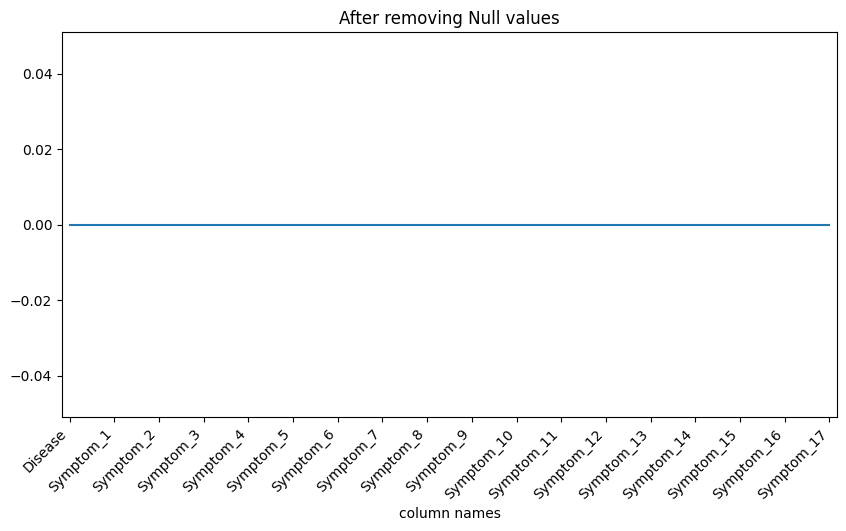

In [15]:
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45,
horizontalalignment='right')
plt.title('After removing Null values')
plt.xlabel('column names')
plt.margins(0.01)
plt.show()

In [16]:
print("Number of symptoms used to identify the disease ",len(df1['Symptom'].unique()))
print("Number of diseases that can be identified ",len(df['Disease'].unique()))

Number of symptoms used to identify the disease  132
Number of diseases that can be identified  41


**Get the names of diseases from data**

In [17]:
df['Disease'].unique()

array(['GERD', 'Hyperthyroidism', 'Hypothyroidism', 'Arthritis',
       'Bronchial Asthma', 'Dimorphic hemmorhoids(piles)',
       '(vertigo) Paroymsal  Positional Vertigo', 'Fungal infection',
       'Hypertension', 'Paralysis (brain hemorrhage)',
       'Cervical spondylosis', 'hepatitis A', 'AIDS', 'Jaundice',
       'Migraine', 'Hepatitis E', 'Chronic cholestasis',
       'Alcoholic hepatitis', 'Diabetes', 'Peptic ulcer diseae',
       'Allergy', 'Drug Reaction', 'Pneumonia', 'Chicken pox', 'Typhoid',
       'Hepatitis B', 'Varicose veins', 'Hepatitis D', 'Psoriasis',
       'Malaria', 'Dengue', 'Impetigo', 'Heart attack', 'Osteoarthristis',
       'Tuberculosis', 'Urinary tract infection', 'Common Cold',
       'Hypoglycemia', 'Gastroenteritis', 'Acne', 'Hepatitis C'],
      dtype=object)

In [18]:
data = df.iloc[:,1:].values
labels = df['Disease'].values

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8,random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3886, 17) (972, 17) (3886,) (972,)


# Decision Tree

F1-score% = 98.02717114437507 | Accuracy% = 97.94238683127571


<Axes: >

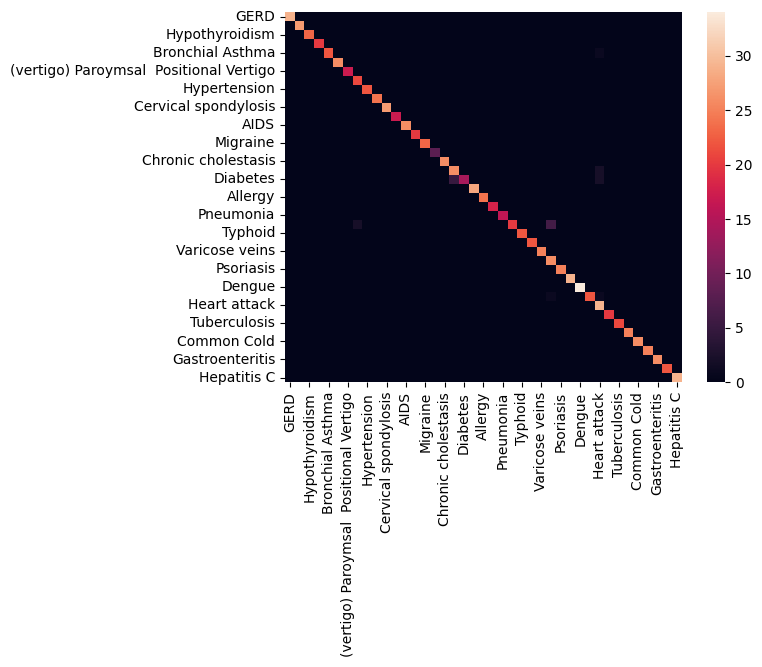

In [20]:
tree =DecisionTreeClassifier(criterion='gini',random_state=42,max_depth=13)
tree.fit(x_train, y_train)
preds=tree.predict(x_test)
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, preds)*100)
sns.heatmap(df_cm)

In [21]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
DS_train =cross_val_score(tree, x_train, y_train, cv=kfold, scoring='accuracy')
pd.DataFrame(DS_train,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (DS_train.mean()*100.0, DS_train.std()*100.0))

Mean Accuracy: 96.371%, Standard Deviation: (1.73%)


In [22]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
DS_test =cross_val_score(tree, x_test, y_test, cv=kfold, scoring='accuracy')
pd.DataFrame(DS_test,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (DS_test.mean()*100.0, DS_test.std()*100.0))

Mean Accuracy: 95.990%, Standard Deviation: (1.48%)


# Random Forest

In [23]:
rfc=RandomForestClassifier(random_state=42)

[4 6 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
Dimorphic hemmorhoids(piles)
F1-score% = 99.53431422043977 | Accuracy% = 99.48559670781893


<Axes: >

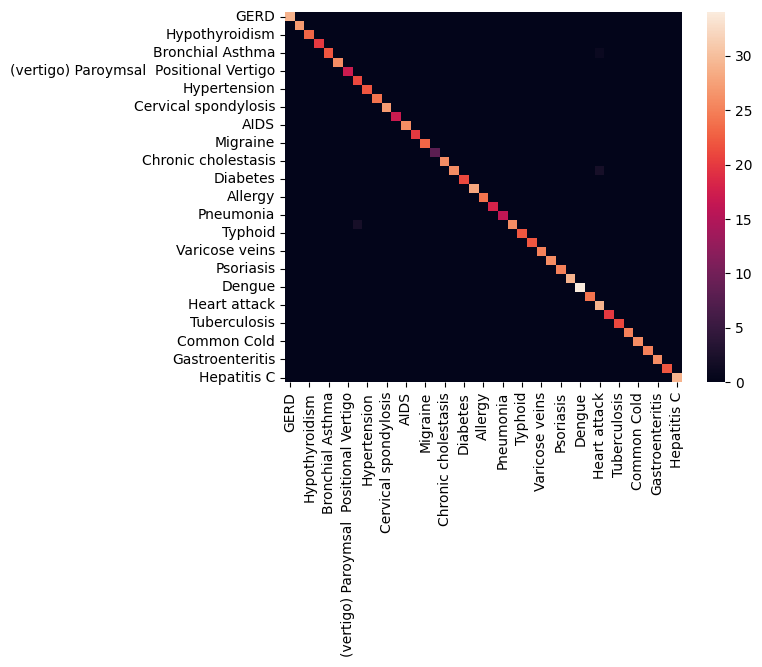

In [24]:
rnd_forest = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=13)
rnd_forest.fit(x_train,y_train)
preds=rnd_forest.predict(x_test)
print(x_test[0])
print(preds[0])
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, preds)*100)
sns.heatmap(df_cm)

In [25]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
rnd_forest_train =cross_val_score(rnd_forest, x_train, y_train, cv=kfold, scoring='accuracy')
pd.DataFrame(rnd_forest_train,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (rnd_forest_train.mean()*100.0, rnd_forest_train.std()*100.0))

Mean Accuracy: 99.279%, Standard Deviation: (0.36%)


In [26]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
rnd_forest_test =cross_val_score(rnd_forest, x_test, y_test, cv=kfold, scoring='accuracy')
pd.DataFrame(rnd_forest_test,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (rnd_forest_test.mean()*100.0, rnd_forest_test.std()*100.0))

Mean Accuracy: 97.944%, Standard Deviation: (1.29%)


**Save Random Forest model**

In [27]:
# save
joblib.dump(tree, "../../models/rf_QuickCheckup.joblib")

['../../models/rf_QuickCheckup.joblib']